### Import libraries as needed

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

### Define helper functions

In [13]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts, title):
    # 'counts' is expected to be a dictionary with class names as keys and counts as values
    # 'title' is the title of the plot
    class_names = list(counts.keys())
    class_counts = list(counts.values())

    plt.figure(figsize=(10, 8))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.xlabel('Class Name')
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate class names for better readability
    plt.title(title)
    plt.show()

############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                print("training phase")
            else:
                model.eval()   # Set model to evaluate mode
                print("eval phase")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Train':
                scheduler.step()

            # epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'bestmodel_resnet50.pth')

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

In [5]:
# Define transformations for the training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Horizontal mirroring
    transforms.RandomRotation(10),  # ±10 degree rotations
    transforms.Grayscale(num_output_channels=3),  # Convert image to RGB
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor image with mean and standard deviation
])

# Define your transformations for the validation and test sets
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert image to RGB
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor image with mean and standard deviation
])

train_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/train'
test_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")

Train dataset size: 23308
Test dataset size: 5834


In [9]:
# Split the test data into validation and test sets
file_names = [item[0] for item in test_data.imgs]
public_files = [name for name in file_names if 'Public' in name]
private_files = [name for name in file_names if 'Private' in name]

public_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Public' in img_path]
private_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]

validation_data = torch.utils.data.Subset(test_data, public_indices)
test_data = torch.utils.data.Subset(test_data, private_indices)

print(f"Validation dataset size: {len(validation_data)}")
print(f"Updated test dataset size: {len(test_data)}")

# Create data loaders
batch_size = 128
num_workers = 2
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

Validation dataset size: 2926
Updated test dataset size: 2908


In [10]:
print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))

Length of Train Loader:  183
Length of Validation Loader:  23


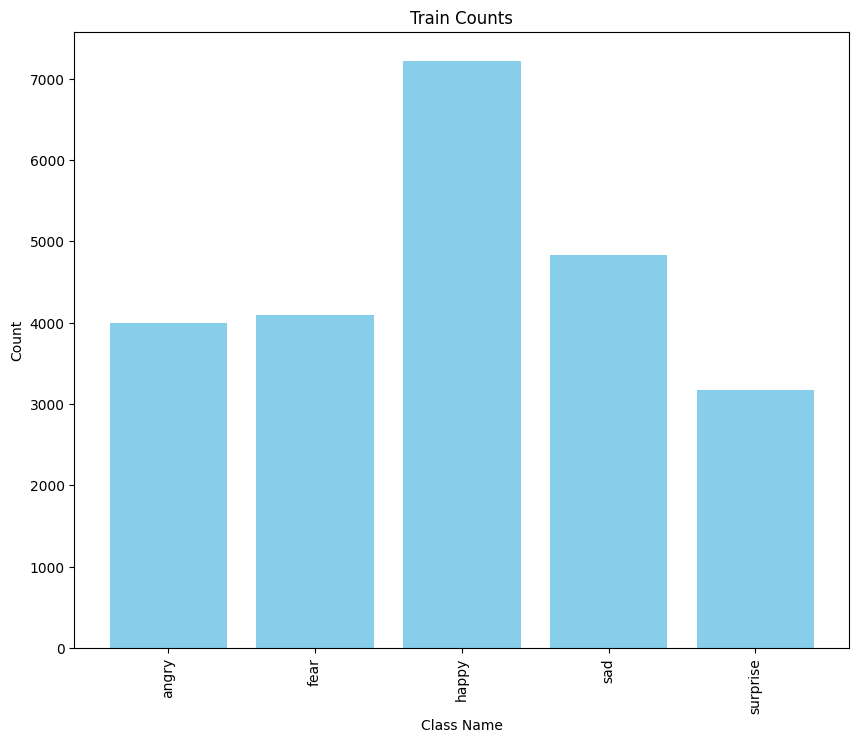

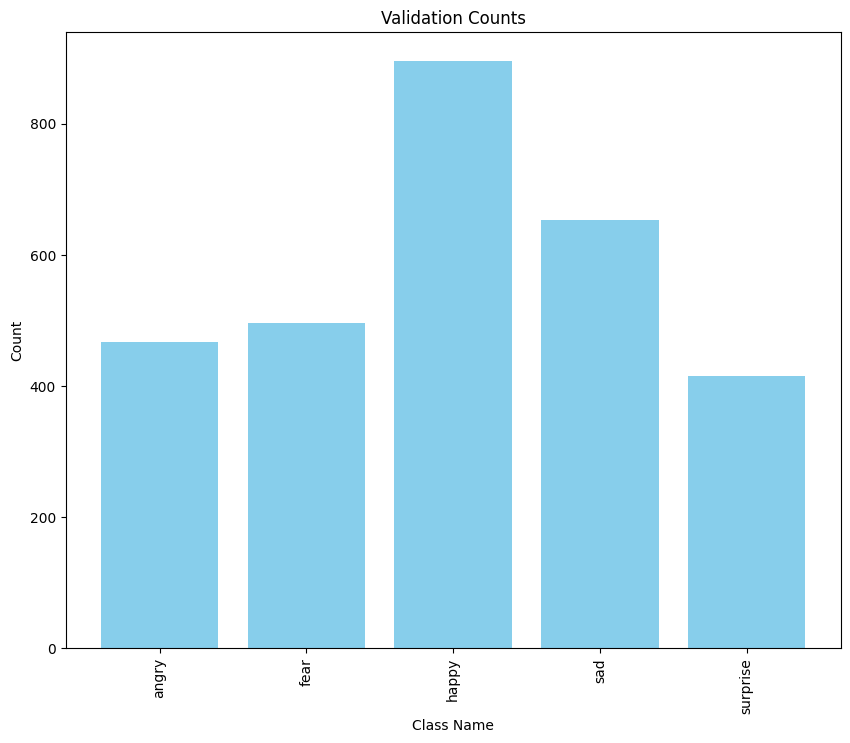

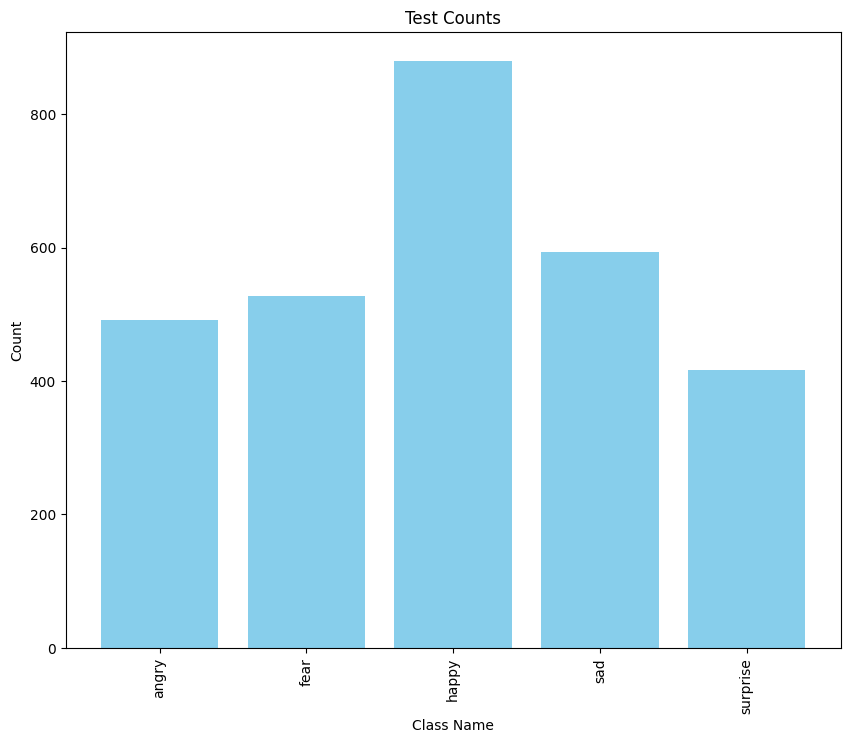

In [14]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Count labels in the original dataset for train
original_counts = Counter(train_data.targets)

# For validation_data
valid_counts = Counter(validation_data.dataset.targets[i] for i in validation_data.indices)
# For test_data
test_counts = Counter(test_data.dataset.targets[i] for i in test_data.indices)

# Convert class indices to class names for the original train dataset
original_counts_named = {idx_to_class[i]: count for i, count in original_counts.items()}

# Convert class indices to class names for the validation dataset
valid_counts_named = {idx_to_class[i]: count for i, count in valid_counts.items()}

# Convert class indices to class names for the test dataset
test_counts_named = {idx_to_class[i]: count for i, count in test_counts.items()}

# Now plot with class names
plot_class_distribution(original_counts_named, 'Train Counts')
plot_class_distribution(valid_counts_named, 'Validation Counts')
plot_class_distribution(test_counts_named, 'Test Counts')

####Data seems to be imbalanced with happy class having a lot more data, remaining classes seem to be somewhat equal

### Visualize some sample from the training set before training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


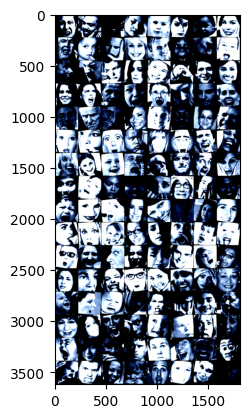

In [15]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Import ResNet50 model and freeze layers + replace classifier to match our number of classes and some basic fc layers with ReLU and end with a softmax activation

In [16]:
model = models.resnet50(pretrained=True)

# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Linear(1024, 5),
    nn.LogSoftmax(dim=1)
)

# Initialize the network and define the loss and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("using gpu")
else:
  print("using cpu")

# Move the model to GPU if available
model = model.to(device)

c:\Users\Anish Patel\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Anish Patel\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


using gpu


Define loss function, step optimizer, learning rate scheduler

In [17]:
# Define the criterion
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss() # try this first

# Define the optimizer (only the parameters of the classifier will be optimized)
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Train the model

In [18]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=30)

Epoch 0/29
----------
training phase
Train Loss: 1.5559 Acc: 0.3050
eval phase
Validation Loss: 1.5385 Acc: 0.3059

Epoch 1/29
----------
training phase
Train Loss: 1.5067 Acc: 0.3198
eval phase
Validation Loss: 1.4889 Acc: 0.3148

Epoch 2/29
----------
training phase
Train Loss: 1.4425 Acc: 0.3839
eval phase
Validation Loss: 1.4150 Acc: 0.3964

Epoch 3/29
----------
training phase
Train Loss: 1.3845 Acc: 0.4215
eval phase
Validation Loss: 1.3879 Acc: 0.4033

Epoch 4/29
----------
training phase
Train Loss: 1.3461 Acc: 0.4392
eval phase
Validation Loss: 1.3521 Acc: 0.4190

Epoch 5/29
----------
training phase
Train Loss: 1.3191 Acc: 0.4484
eval phase
Validation Loss: 1.3146 Acc: 0.4504

Epoch 6/29
----------
training phase
Train Loss: 1.3077 Acc: 0.4540
eval phase
Validation Loss: 1.3169 Acc: 0.4484

Epoch 7/29
----------
training phase
Train Loss: 1.2943 Acc: 0.4587
eval phase
Validation Loss: 1.3041 Acc: 0.4504

Epoch 8/29
----------
training phase
Train Loss: 1.2940 Acc: 0.4643
eval

### Plot the loss and accuracy values during training for the train and validation sets

In [1]:
# Plot the history
plot_history(history)

NameError: name 'plot_history' is not defined

### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [ ]:
# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [2]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

NameError: name 'calculate_metrics' is not defined

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)